In [1]:
#%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
Precip = session.query(Measurement).first()
Precip.__dict__
engine.execute('SELECT * FROM Measurement LIMIT 10').fetchall()

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
    
# Calculate the date 1 year ago from today
session.query(func.count(Measurement.date)).all()
    # basically we have 19550 dates from Jan 1, 2010 to Aug 23, 2017
    # It doesn't make sense to go back a year from today, so I'll go back between 2 and 1 years ago from today.
session.query(Measurement.date).order_by(Measurement.date.asc()).first()

end = dt.date(2017,8,23)

start = end - dt.timedelta(days=365)
start

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


datetime.date(2016, 8, 23)

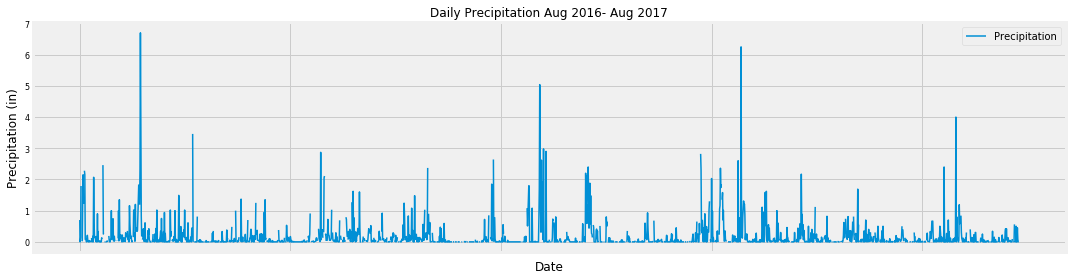

In [37]:
# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start).filter(Measurement.date <= end).order_by(Measurement.date.desc()).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
Precip_df = pd.DataFrame(prcp_query)
# Sort the dataframe by date
Precip_df = Precip_df.sort_values("date", ascending=True)
Precip_df.head()
Precip_df = Precip_df.rename(columns={"date": "Date", "prcp": "Precipitation"})

# Check on how many precip observations per date
Date_groups = Precip_df.groupby("Date")["Precipitation"].count()
Date_groups.value_counts()

#Group by Date
Date_precip = Precip_df.groupby("Date")["Precipitation"].mean()
Date_precip.count()

#Set the index to "Date" for the plot
Precip_df = Precip_df.set_index("Date", drop=True)


# Use Pandas Plotting with Matplotlib to plot the data
Precip_plot = Precip_df.plot(kind="line", figsize=(15,4), fontsize=8, rot=90, grid=True, legend=True, linewidth=1.5)
Precip_plot.set_title("Daily Precipitation Aug 2016- Aug 2017", fontsize=12)
Precip_plot.set_xlabel("Date", fontsize=12)
Precip_plot.set_ylabel("Precipitation (in)", fontsize=12)

plt.tight_layout()

# Rotate the xticks for the dates
    # Already done above (rot=90), but dates dont show up because its a line graph, with too many points
    # Also note, there are multiple observations for a single date, below I redo the analysis and take the mean precip per date
plt.show()

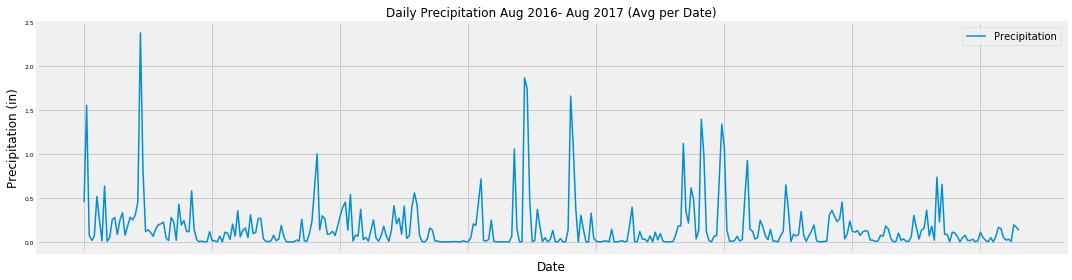

In [36]:
# Take the average precipitation per date
Date_precip_df = pd.DataFrame(Date_precip)
Date_precip_df

Dates_plot = Date_precip_df.plot(kind="line", figsize=(15,4), fontsize=6, rot=90, grid=True, legend=True, linewidth=1.5)
Dates_plot.set_title("Daily Precipitation Aug 2016- Aug 2017 (Avg per Date)", fontsize=12)
Dates_plot.set_xlabel("Date", fontsize=12)
Dates_plot.set_ylabel("Precipitation (in)", fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Summary = pd.DataFrame.describe(Precip_df)
Summary
    # Note that my df has more observations because I used all observations between Aug 10, 2016 and Aug 10, 2017

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Ok this is getting a bit confusing, I want to look at average and sum of rain per month so I can better plan my trip
Date_precip_df
Date_precip_df = Date_precip_df.reset_index(drop=False)
Date_precip_df.head()
month = []
for date in Date_precip_df["Date"]:
    datereal = dt.datetime.strptime(date, "%Y-%m-%d")
    month.append(datereal.strftime("%m"))
Date_precip_df["Month"] = month

Month_avg = Date_precip_df.groupby("Month")["Precipitation"].mean()
Month_sum = Date_precip_df.groupby("Month")["Precipitation"].sum()
Month_summary = pd.DataFrame({"Average Precip":Month_avg, "Total Precip":Month_sum})
Month_summary = Month_summary.sort_values("Average Precip", ascending=True)
Month_summary

# As a result of this exploration, I think I'd like to take my vacation in January or June, combining this with the chart
# above, I actually think January is the best, as it seems to be dry for the first 3 weeks of the month.

,Average Precip,Total Precip
Month,,
01,0.075740,2.347952
06,0.119904,3.597119
10,0.120344,3.730667
11,0.130408,3.912238
07,0.132918,4.120452
05,0.147737,4.579833
08,0.155202,4.966476
03,0.157887,4.894500
12,0.199009,6.169286


## Station Analysis

In [15]:
# How many stations are available in this dataset?
Stations = session.query(Measurement).group_by(Measurement.station).count()
Stations

9

In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.

# Let's join them so we can get the station names as well
sel = [Measurement.station, Measurement.date, Measurement.prcp, Measurement.id, Station.name]
Stations_join = pd.DataFrame(session.query(*sel).filter(Measurement.station==Station.station).all())
Stations_join.head()

Stations_active = pd.DataFrame(Stations_join.groupby("name")["id"].count())
Stations_active = Stations_active.sort_values("id", ascending=False)
print(Stations_active)

# Below is another way of doing it without the join, using station #s instead of names
Stationary = session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()
stations_df = pd.DataFrame(Stationary, columns=["Station", "Observations"])
stations_df = stations_df.set_index("Station", drop=True)
print(stations_df)


                                          id
name                                        
WAIHEE 837.5, HI US                     2772
WAIKIKI 717.2, HI US                    2724
KANEOHE 838.1, HI US                    2709
WAIMANALO EXPERIMENTAL FARM, HI US      2669
MANOA LYON ARBO 785.2, HI US            2612
KUALOA RANCH HEADQUARTERS 886.9, HI US  2202
HONOLULU OBSERVATORY 702.2, HI US       1979
PEARL CITY, HI US                       1372
UPPER WAHIAWA 874.3, HI US               511
             Observations
Station                  
USC00519281          2772
USC00513117          2696
USC00519397          2685
USC00519523          2572
USC00516128          2484
USC00514830          1937
USC00511918          1932
USC00517948           683
USC00518838           342


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature [at the] most active station?
sel = [Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)]

Highs_and_Lows = session.query(*sel).filter(Measurement.station=="USC00519281").all()
print(Highs_and_Lows)

[('USC00519281', 85.0, 54.0, 71.66378066378067)]


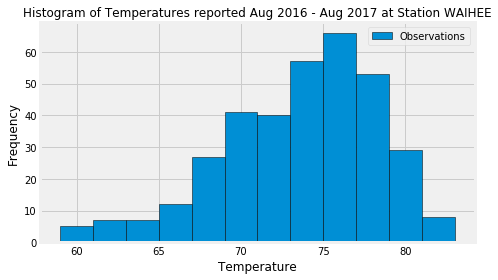

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
end = dt.date(2017,8,23)

start = end - dt.timedelta(days=365)
start

twelve_month_temp = session.query(Measurement.tobs).filter(Measurement.station=="USC00519281").filter(Measurement.date >= start).filter(Measurement.date <= end).all()
TMT = pd.DataFrame(twelve_month_temp)
TMT.head()
plt.figure(figsize=(7,4))
plt.hist(TMT["tobs"], bins=12, align="mid", orientation="vertical", label="Observations", edgecolor="black")
plt.legend(loc="best")
plt.title("Histogram of Temperatures reported Aug 2016 - Aug 2017 at Station WAIHEE", fontsize=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.tight_layout()
plt.show()

## Temperature Analysis

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-01-03'
end_date = '2017-01-18'
Temps = calc_temps(start_date, end_date)
Temps[0][0]
print(f"January 3 to January 18. Min temp: {Temps[0][0]}. Max temp: {Temps[0][2]}. Average temp: {Temps[0][1]}")

January 3 to January 18. Min temp: 60.0. Max temp: 81.0. Average temp: 69.16494845360825


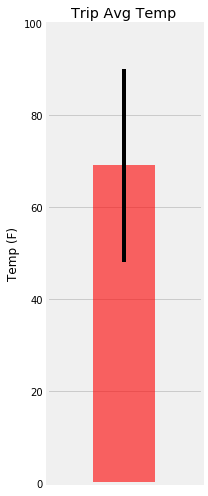

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(3,7))
plt.bar(1,Temps[0][1], yerr=Temps[0][2]-Temps[0][0], color="red", alpha=0.6)
plt.ylim(0,100)
plt.xlim(0,2,1)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.grid(False)
plt.gca().yaxis.grid(True)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tight_layout()
plt.show()
# Need to get rid of x-axis

## Rainfall per Weather Station (during proposed trip dates)

In [26]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Start with a join
sel = [Measurement.station, Measurement.date, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]
Stations_rainfall = session.query(*sel).filter(Measurement.station==Station.station).filter(Measurement.date >= start_date) \
                   .filter(Measurement.date <=end_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

Stations_df = pd.DataFrame(Stations_rainfall, columns=["Station ID", "Date", "Total Precip", "Station Name", "Lat", "Lng", "Elevation"])
Stations_df = Stations_df[["Station ID", "Station Name", "Total Precip", "Lat", "Lng", "Elevation"]]
Stations_df

,Station ID,Station Name,Total Precip,Lat,Lng,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.68,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.62,21.52130,-157.83740,7.0
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.61,21.33556,-157.71139,19.5
3,USC00519281,"WAIHEE 837.5, HI US",0.17,21.45167,-157.84889,32.9
4,USC00513117,"KANEOHE 838.1, HI US",0.06,21.42340,-157.80150,14.6
5,USC00517948,"PEARL CITY, HI US",0.00,21.39340,-157.97510,11.9
6,USC00519397,"WAIKIKI 717.2, HI US",0.00,21.27160,-157.81680,3.0


## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2017,1,3)
end_date = dt.date(2017,1,18)

# Use the start and end date to create a range of dates
Days = (end_date - start_date).days
Days

date_list = [end_date - dt.timedelta(days=x) for x in range(0, Days+1)]
date_list
# Stip off the year and save a list of %m-%d strings
dates_str = [date.strftime("%m-%d") for date in date_list]
dates_str

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms = []
for date in dates_str:
    daily_norms.append(daily_normals(date))
daily_norms

lows = []
avgs = []
highs = []
for x in range(len(daily_norms)):
    lows.append(daily_norms[x][0][0])
    avgs.append(daily_norms[x][0][1])
    highs.append(daily_norms[x][0][2])
               
lows

[57.0,
 61.0,
 54.0,
 56.0,
 58.0,
 57.0,
 57.0,
 57.0,
 62.0,
 58.0,
 57.0,
 57.0,
 61.0,
 56.0,
 58.0,
 62.0]

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Dailies_df = pd.DataFrame({"Date":dates_str, "Low Temp":lows, "Avg Temp":avgs, "High Temp":highs})
Dailies_df = Dailies_df.set_index("Date", drop=True)
Dailies_df

,Avg Temp,High Temp,Low Temp
Date,,,
01-18,68.631579,77.0,57.0
01-17,69.074074,76.0,61.0
01-16,68.629630,80.0,54.0
01-15,69.313725,78.0,56.0
01-14,69.526316,77.0,58.0
01-13,67.254545,77.0,57.0
01-12,67.407407,81.0,57.0
01-11,67.310345,78.0,57.0
01-10,69.741379,77.0,62.0


[Text(0,0,'01-18'),
 Text(0,0,'01-17'),
 Text(0,0,'01-16'),
 Text(0,0,'01-15'),
 Text(0,0,'01-14'),
 Text(0,0,'01-13'),
 Text(0,0,'01-12'),
 Text(0,0,'01-11'),
 Text(0,0,'01-10'),
 Text(0,0,'01-09')]

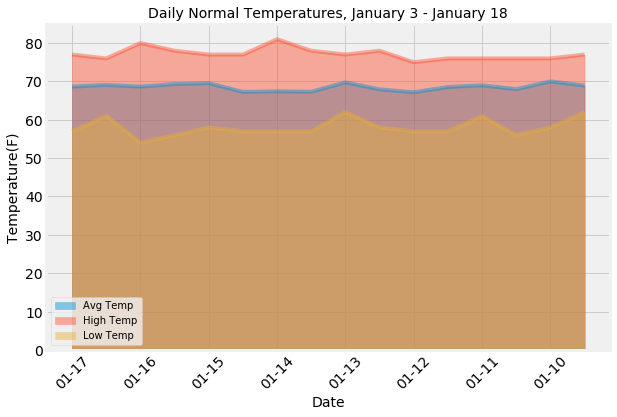

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
DDF_plot = Dailies_df.plot(kind="area", stacked=False, alpha=0.45, figsize=(9,6), rot=45, fontsize=14)
DDF_plot.set_title("Daily Normal Temperatures, January 3 - January 18", fontsize=14)
DDF_plot.set_ylabel("Temperature(F)", fontsize=14)
DDF_plot.set_xlabel("Date", fontsize=14)
DDF_plot.set_xticklabels(Dailies_df.index)

In [46]:
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start).filter(Measurement.date <= end).order_by(Measurement.date.desc()).all()
daterains = []
for i in prcp_query:
    print(i[1])
    #date=(prcp_query[i][0])
    #prcp=(prcp_query[i][1])
    #daterain = {"date":date, "prcp":prcp}
    #daterains.append(daterain)

0.0
0.0
0.08
0.45
0.0
0.0
0.5
0.0
0.02
None
0.56
0.0
0.01
None
0.0
0.0
None
0.09
0.0
0.0
0.06
None
0.0
0.05
0.01
0.13
0.0
0.07
0.12
0.42
0.02
0.0
0.06
0.32
0.42
0.0
0.01
0.08
0.0
0.22
0.0
None
0.0
0.0
None
0.0
0.0
0.14
0.0
0.0
0.0
None
0.0
0.0
0.0
0.07
0.0
0.0
0.15
0.0
0.1
0.0
0.34
0.0
0.0
0.0
0.05
0.0
0.0
0.0
0.0
None
0.0
0.06
None
0.02
0.04
0.0
0.0
0.0
0.01
0.0
0.06
0.0
0.05
0.0
0.25
0.02
0.12
0.0
None
0.0
0.0
None
None
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3
0.0
0.06
0.02
0.0
0.23
0.3
0.0
0.13
0.14
0.01
0.0
0.09
0.4
0.0
0.0
0.0
None
0.0
0.01
0.0
0.0
0.06
0.02
None
0.0
0.12
0.3
0.0
0.03
0.12
0.0
0.05
0.11
0.3
0.05
0.58
1.19
None
0.61
0.84
0.0
0.06
0.07
0.2
0.8
0.03
0.07
0.12
0.0
0.2
4.0
0.0
0.0
0.0
0.0
0.0
0.03
0.1
0.03
0.12
0.0
0.0
0.33
0.06
0.7
0.0
0.09
0.0
0.0
0.05
0.27
0.05
0.03
0.0
0.0
0.0
0.05
2.4
0.03
0.12
0.16
0.0
0.21
0.39
0.02
0.07
0.12
0.0
0.1
0.5
0.0
0.03
0.01
0.0
0.05
0.1
0.02
0.05
0.0
0.0
0.2
0.68
0.07
0.33
0.3
None
0.11
0.32
0.68
0.0
0.01
0.02
None
0.0
0.28
0.05
0.0
0.01
0.0
N

0.0
0.0
0.0
None
0.0
0.0
0.01
0.0
0.05
0.0
0.07
0.0
0.0
0.04
0.0
0.0
0.0
None
0.0
0.01
0.81
0.0
0.0
0.0
None
0.0
0.03
3.46
0.0
0.04
0.03
None
0.0
0.16
0.46
0.0
0.02
0.03
0.0
0.06
0.61
0.0
0.14
0.08
0.07
0.14
1.02
0.0
0.31
0.06
None
0.15
0.25
0.38
0.0
0.49
0.2
0.04
0.18
0.59
1.49
0.0
0.08
0.0
0.0
0.0
0.0
0.05
0.02
0.12
0.0
0.05
0.17
1.0
0.06
0.06
0.02
None
0.34
0.17
1.02
0.0
0.02
0.0
0.0
0.03
0.04
0.0
0.0
0.0
0.0
0.01
0.27
0.0
0.15
0.15
0.0
0.0
0.94
0.33
0.02
0.09
0.17
0.06
0.01
0.34
0.75
0.0
0.06
0.02
0.0
0.07
1.02
0.0
0.09
0.25
0.0
0.04
0.22
0.43
0.0
0.01
None
None
0.05
0.01
0.25
0.0
0.0
0.04
0.07
0.42
0.05
0.04
0.0
0.36
0.23
0.06
0.01
0.07
0.0
0.01
0.06
0.61
0.42
0.12
0.07
None
0.17
0.83
3.35
1.32
0.9
1.84
None
1.19
2.33
6.7
0.02
0.37
0.32
None
0.46
0.34
1.2
0.0
0.04
None
None
0.15
0.31
1.04
0.05
0.18
0.12
0.3
0.6
0.0
0.01
0.14
0.09
1.16
0.03
0.01
0.29
None
0.23
0.16
0.35
0.0
0.22
0.01
None
0.01
0.07
0.15
0.05
0.1
0.23
0.11
0.16
1.35
None
0.05
0.04
0.03
0.11
1.0
None
0.11
None
0.02
0